In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data.csv')
df.head()

,age,sex,on_thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative.|3733
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative.|1442
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative.|2965
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative.|806
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative.|2807


In [4]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U',
       'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source',
       'class'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [6]:
df.shape

(3772, 30)

Fixing the class name

In [7]:
c = 0
for i in df['class']:
    j = i.index('|')
    j = i[:j-1]
    df['class'][c] = j
    c += 1

Replacing ? with Nan

In [8]:
for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count!=0:
        print(column, count)

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


TBG column is completely empty so dropping the column

In [9]:
df.drop(columns=['TBG'],inplace=True)

Some columns have t f data regarding if the next column has value or not which is of no use

In [10]:
df[['TSH measured', 'TSH']].head()

,TSH measured,TSH
0,t,1.3
1,t,4.1
2,t,0.98
3,t,0.16
4,t,0.72


Dropping such columns

In [11]:
redundant_columns = ['TSH measured','T3 measured','TT4 measured','T4U measured','FTI measured','TBG measured']
df.drop(columns=redundant_columns,inplace=True)
#df

Making the ? vals as nan

In [12]:
for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count!=0:
        df[column] = df[column].replace('?',np.nan)

In [13]:
df.isnull().sum()

age                            1
sex                          150
on_thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral source                0
class                          0
dtype: int64

Converting t/f and m/f to 0/1

In [14]:
df['sex'] = df['sex'].map({'F':0,'M':1})

for column in df.columns:
    if column == 'sex':
        pass
    elif df[column].nunique() == 2:
        df[column] = df[column].map({'f':0,'t':1})
    else:
        pass

#df

Making referral source dummies

In [15]:
df = pd.get_dummies(df, columns=['referral source'])
#df

Using encoder to assign numerical values to class

In [16]:
from sklearn.preprocessing import LabelEncoder
import pickle
encoder = LabelEncoder().fit(df['class'])

df['class'] = encoder.transform(df['class'])

# we will save the encoder as pickle to use when we do the prediction. We will need to decode the predcited values
# back to original

file = "enc.pickle"
pickle.dump(encoder, open(file, "wb"))

Imputing values

In [17]:
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(df) # impute the missing values
# convert the nd-array returned in the step above to a Dataframe
new_df=pd.DataFrame(data=np.round(new_array,2), columns=df.columns)
#new_df

Checking the distribution of columns with numerical data

In [40]:
#columns = ['age','TSH','T3','TT4','T4U','FTI']
#
#plt.figure(figsize=(10,15),facecolor='white')
#plotnumber = 1
#
#for column in columns:
#    ax = plt.subplot(3,2,plotnumber)
#    sns.distplot(new_df[column])
#    plt.xlabel(column,fontsize=10)
#    plotnumber+=1
#plt.show()

In [18]:
new_df.drop(columns=['TSH'],inplace=True) #TSH is not normal distribution and wont help much

Checking if target is balanced

<AxesSubplot: xlabel='class', ylabel='count'>

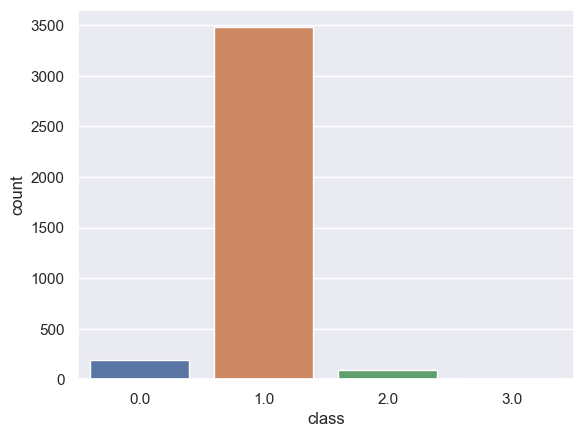

In [19]:
sns.countplot(x=new_df['class'])

To deal with imbalanced data using random sampling

In [23]:
from imblearn.over_sampling import RandomOverSampler
x = new_df.drop(['class'],axis=1)
y = new_df['class']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x,y)
x_sampled.shape
data = x_sampled.copy()
data.drop("query on thyroxine", axis = 1, inplace = True)
data.drop("sick", axis = 1, inplace = True)
data.drop("pregnant", axis = 1, inplace = True)
data.drop("thyroid surgery", axis = 1, inplace = True)
data.drop("I131 treatment", axis = 1, inplace = True)
data.drop("query hypothyroid", axis = 1, inplace = True)
data.drop("query hyperthyroid", axis = 1, inplace = True)
data.drop("lithium", axis = 1, inplace = True)
data.drop("tumor", axis = 1, inplace = True)
data.drop("referral source_SVHC", axis = 1, inplace = True)
data.drop("referral source_SVHD", axis = 1, inplace = True)
data.drop("referral source_SVI", axis = 1, inplace = True)
data.drop("referral source_other", axis = 1, inplace = True)
data.drop("referral source_STMW", axis = 1, inplace = True)
data

,age,sex,on_thyroxine,on antithyroid medication,goitre,hypopituitary,psych,T3,TT4,T4U,FTI
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,125.0,1.14,109.00
1,23.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,102.0,0.97,107.67
2,46.0,1.0,0.0,0.0,0.0,0.0,0.0,1.63,109.0,0.91,120.00
3,70.0,0.0,1.0,0.0,0.0,0.0,0.0,1.90,175.0,1.00,176.67
4,70.0,0.0,0.0,0.0,0.0,0.0,0.0,1.20,61.0,0.87,70.00
...,...,...,...,...,...,...,...,...,...,...,...
13919,41.0,1.0,0.0,0.0,0.0,0.0,0.0,2.50,22.0,0.91,57.33
13920,41.0,1.0,0.0,0.0,0.0,0.0,0.0,2.50,22.0,0.91,57.33
13921,46.0,0.0,0.0,0.0,0.0,0.0,0.0,1.20,48.0,0.89,54.00
13922,46.0,0.0,0.0,0.0,0.0,0.0,0.0,1.20,48.0,0.89,54.00


In [24]:
from sklearn.cluster import KMeans
def create_clusters(data,number_of_clusters):
        """
                                Method Name: create_clusters
                                Description: Create a new dataframe consisting of the cluster information.
                                Output: A datframe with cluster column
                                On Failure: Raise Exception

      """
        
        try:
            kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=0)
            
            y_kmeans=kmeans.fit_predict(data) #  divide data into clusters


            data['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
            print('succesfully created '+str(f"{number_of_clusters}")+ ' clusters. Exited the create_clusters method of the KMeansClustering class')
            return data

        except Exception as e:
          print(e)


#Creating clusters
data = create_clusters(data,3)

succesfully created 3 clusters. Exited the create_clusters method of the KMeansClustering class


In [25]:
#Adding data labels into x
data['Labels']=y_sampled

In [53]:
from sklearn.model_selection import train_test_split
cluster_data=data[data['Cluster']==1]
cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
cluster_label= cluster_data['Labels']

# splitting the data into training and test set for each cluster one by one
x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=0)

,age,sex,on_thyroxine,on antithyroid medication,goitre,hypopituitary,psych,T3,TT4,T4U,FTI
8631,84.0,0.00,0.0,0.0,0.0,0.0,0.0,0.7,52.0,1.11,47.00
11437,41.0,1.00,0.0,0.0,0.0,0.0,0.0,2.5,22.0,0.91,57.33
8019,77.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,33.0,0.67,49.00
9039,31.0,0.00,0.0,0.0,0.0,0.0,0.0,1.3,63.0,1.19,53.00
8829,60.0,0.00,0.0,0.0,0.0,0.0,0.0,1.1,45.0,0.97,46.00
...,...,...,...,...,...,...,...,...,...,...,...
12031,41.0,1.00,0.0,0.0,0.0,0.0,0.0,2.5,22.0,0.91,57.33
10355,53.0,0.00,0.0,0.0,0.0,0.0,0.0,0.3,13.0,0.99,13.00
8589,77.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,33.0,0.67,49.00
9641,50.0,0.00,0.0,0.0,0.0,0.0,0.0,0.2,33.0,0.70,47.00


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [28]:
def get_best_params_for_random_forest(train_x,train_y):
        """
                                Method Name: get_best_params_for_random_forest
                                Description: get the parameters for Random Forest Algorithm which give the best accuracy.
                                             Use Hyper Parameter Tuning.
                                Output: The model with the best parameters
                                On Failure: Raise Exception

        """
        print('Entered the get_best_params_for_random_forest method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}

            clf = RandomForestClassifier()
        
            #Creating an object of the Grid Search class
            grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,  verbose=3)
            #finding the best parameters
            grid.fit(train_x, train_y)

            #extracting the best parameters
            criterion = grid.best_params_['criterion']
            max_depth = grid.best_params_['max_depth']
            max_features = grid.best_params_['max_features']
            n_estimators = grid.best_params_['n_estimators']

            #creating a new model with the best parameters
            clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                              max_depth=max_depth, max_features=max_features)
            # training the mew model
            clf.fit(train_x, train_y)
            
            print('Random Forest best params: '+str(f"{grid.best_params_}")+'. Exited the get_best_params_for_random_forest method of the Model_Finder class')

            return clf
        except Exception as e:
          raise Exception()

In [29]:
def get_best_params_for_KNN(train_x, train_y):
        """
                                                Method Name: get_best_params_for_KNN
                                                Description: get the parameters for KNN Algorithm which give the best accuracy.
                                                             Use Hyper Parameter Tuning.
                                                Output: The model with the best parameters
                                                On Failure: Raise Exception

        """
        print('Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class')
        try:
            #initializing with different combination of parameters
            param_grid_knn = {
                'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                'leaf_size' : [10,17,24,28,30,35],
                'n_neighbors':[4,5,8,10,11],
                'p':[1,2]
            }

            knn = KNeighborsClassifier()
            #Creating an object of the Grid Search class
            grid = GridSearchCV(knn, param_grid_knn, verbose=3,cv=5)
            # finding the best parameters
            grid.fit(train_x, train_y)

            # extracting the best parameters
            algorithm =grid.best_params_['algorithm']
            leaf_size = grid.best_params_['leaf_size']
            n_neighbors = grid.best_params_['n_neighbors']
            p  = grid.best_params_['p']

            # creating a new model with the best parameters
            knn = KNeighborsClassifier(algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors,p=p,n_jobs=-1)
            # training the mew model
            knn.fit(train_x, train_y)
            print('KNN best params: ' + str(f"{grid.best_params_}") + '. Exited the KNN method of the Model_Finder class')
            return knn

        except Exception as e:
            raise Exception()

In [30]:
def get_best_params_for_xgboost(train_x,train_y):
   """
                                      Method Name: get_best_params_for_xgboost
                                      Description: get the parameters for XGBoost Algorithm which give the best accuracy.
                                      Use Hyper Parameter Tuning.

                                      Output: The model with the best parameters
                                      On Failure: Raise Exception
                              
   """




        
   print('Entered the get_best_params_for_xgboost method of the Model_Finder class')
   try:
     # initializing with different combination of parameters
     param_grid_xgboost = {
    
                 'learning_rate': [0.5, 0.1, 0.01, 0.001],
                 'max_depth': [3, 5, 10, 20],
                 'n_estimators': [10, 50, 100, 200]
    
             }
     # Creating an object of the Grid Search class
     grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid_xgboost, verbose=3,cv=5)
     # finding the best parameters
     grid.fit(train_x, train_y)
    
     # extracting the best parameters
     learning_rate = grid.best_params_['learning_rate']
     max_depth = grid.best_params_['max_depth']
     n_estimators = grid.best_params_['n_estimators']
    
     # creating a new model with the best parameters
     xgb = XGBClassifier(learning_rate=1, max_depth=5, n_estimators=50)
     # training the mew model
     xgb.fit(train_x, train_y)
     print('XGBoost best params: ' + str(f"{grid.best_params_}") + '. Exited the get_best_params_for_xgboost method of the Model_Finder class')
            

     return xgb
   except Exception as e:
     raise Exception()


In [31]:
random_forest_classifier = get_best_params_for_random_forest(x_train,y_train)

Entered the get_best_params_for_random_forest method of the Model_Finder class
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.953 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.973 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.978 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.973 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.974 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.966 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.978 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.97

In [32]:
knn_classifier = get_best_params_for_KNN(x_train, y_train)

Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.992 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.995 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbor

In [33]:
xgb_classifier = get_best_params_for_xgboost(x_train,y_train)

Entered the get_best_params_for_xgboost method of the Model_Finder class
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.996 total time=   1.2s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.991 total time=   0.0s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.996 total time=   0.0s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.996 total time=   0.0s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.996 total time=   0.0s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.993 total time=   0.0s
[CV 5/5] END learni

In [34]:
def get_best_model(train_x,train_y,test_x,test_y):
        """
                                                Method Name: get_best_model
                                                Description: Find out the Model which has the best AUC score.
                                                Output: The best model name and the model object
                                                On Failure: Raise Exception

        """
        print('Entered the get_best_model method of the Model_Finder class')
        # create best model for KNN
        try:
            #knn= get_best_params_for_KNN(train_x,train_y)
            knn = knn_classifier
            prediction_knn = knn.predict_proba(test_x) # Predictions using the KNN Model

            if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                knn_score = accuracy_score(test_y, prediction_knn)
                print('Accuracy for knn:' + str(knn_score))  # Log AUC
            else:
                knn_score = roc_auc_score(test_y, prediction_knn, multi_class='ovr') # AUC for KNN
                print('AUC for knn:' + str(knn_score)) # Log AUC

            # create best model for Random Forest
            #random_forest= get_best_params_for_random_forest(train_x,train_y)
            random_forest = random_forest_classifier
            prediction_random_forest=random_forest.predict_proba(test_x) # prediction using the Random Forest Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                random_forest_score = accuracy_score((test_y),prediction_random_forest)
                print('Accuracy for RF:' + str(random_forest_score))
            else:
                random_forest_score = roc_auc_score((test_y), prediction_random_forest,multi_class='ovr') # AUC for Random Forest
                print('AUC for RF:' + str(random_forest_score))

            # create best model for XGBoost
            #xgb= get_best_params_for_xgboost(train_x,train_y)
            xgb = xgb_classifier
            prediction_xgb=xgb.predict_proba(test_x) # prediction using the XGBoost Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                xgb_score = accuracy_score((test_y),prediction_xgb)
                print('Accuracy for XGB:' + str(xgb_score))
            else:
                xgb_score = roc_auc_score((test_y), prediction_xgb,multi_class='ovr') # AUC for XGBoost
                print('AUC for XGB:' + str(xgb_score))

            #comparing the models
            if(random_forest_score < knn_score):
                if(xgb_score < knn_score):
                    return 'KNN', knn
                else:
                    return 'XBG', xgb
            
            else:
                if(random_forest_score < xgb_score):
                    return 'XBG', xgb
                else:
                    return 'RandomForest', random_forest
  
        except Exception as e:
            print('Exception occured in get_best_model method of the Model_Finder class. Exception message:  ' + str(e))
            print('Model Selection Failed. Exited the get_best_model method of the Model_Finder class')

            raise Exception()

In [49]:
best_model_name , best_model  = get_best_model(x_train,y_train,x_test,y_test)

Entered the get_best_model method of the Model_Finder class
AUC for knn:0.9255808580793047
AUC for RF:0.9881647170800365
AUC for XGB:0.9944921234070909


In [50]:
pred_xgb = xgb_classifier.predict(x_test)
pred_xgb

array([2, 2, 3, ..., 2, 2, 3], dtype=int64)

In [51]:
x_test.head()

,age,sex,on_thyroxine,on antithyroid medication,goitre,hypopituitary,psych,T3,TT4,T4U,FTI
8102,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,10.0,1.13,9.0
10241,67.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,0.98,49.0
10854,46.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,48.0,0.89,54.0
9820,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,18.0,1.09,16.0
8454,63.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4,14.0,0.98,14.0


In [59]:
xgb_classifier.predict(x_test)
#x_test.iloc[0]

array([2, 2, 3, ..., 2, 2, 3], dtype=int64)

In [61]:
pred_rf = random_forest_classifier.predict(x_test)
pred_rf

array([2., 2., 3., ..., 2., 2., 3.])

In [66]:
random_forest_classifier.predict([[50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,10.0,1.13,9.0]])

array([2.])

In [67]:
enc =  pickle.load(open('enc.pickle','rb'))
enc.inverse_transform([2])

array(['primary hypothyroid'], dtype=object)